<a href="https://colab.research.google.com/github/MuhammadMuneebFida/MSDS19091_COVID19_DLSpring2020/blob/master/covid19_classification_focal_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VGG Task 1

In [1]:
from google.colab import drive
drive.mount('./gdrive')


Drive already mounted at ./gdrive; to attempt to forcibly remount, call drive.mount("./gdrive", force_remount=True).


In [2]:
!unzip "./gdrive/My Drive/Copy of A_05_Part_02_Dataset.zip"

Archive:  ./gdrive/My Drive/Copy of A_05_Part_02_Dataset.zip
replace A_05_Part_02_Dataset/Test/0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
trainPath='/content/A_05_Part_02_Dataset/Train'
validPath='/content/A_05_Part_02_Dataset/Validation'


In [0]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.optim import lr_scheduler
# from torch.autograd import Variable
# import numpy as np
# import torchvision
# from torchvision import datasets, models, transforms
# import matplotlib.pyplot as plt
# import time
# import os
# import copy
# from sklearn.metrics import accuracy_score
import cv2
import glob
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch import cuda
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [5]:
# from sklearn.metrics import accuracy_score
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((224,224)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])

valid_transforms = transforms.Compose([transforms.Resize((224,224)),

                                      transforms.ToTensor()])


test_transforms = transforms.Compose([transforms.Resize((224,224)),

                                      transforms.ToTensor()])
#pass transform here-in
train_data = torchvision.datasets.ImageFolder(trainPath , transform=train_transforms)
valid_data=torchvision.datasets.ImageFolder(validPath , transform=train_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True,num_workers=4)
validloader=torch.utils.data.DataLoader(valid_data, batch_size=64, shuffle=True,num_workers=4)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


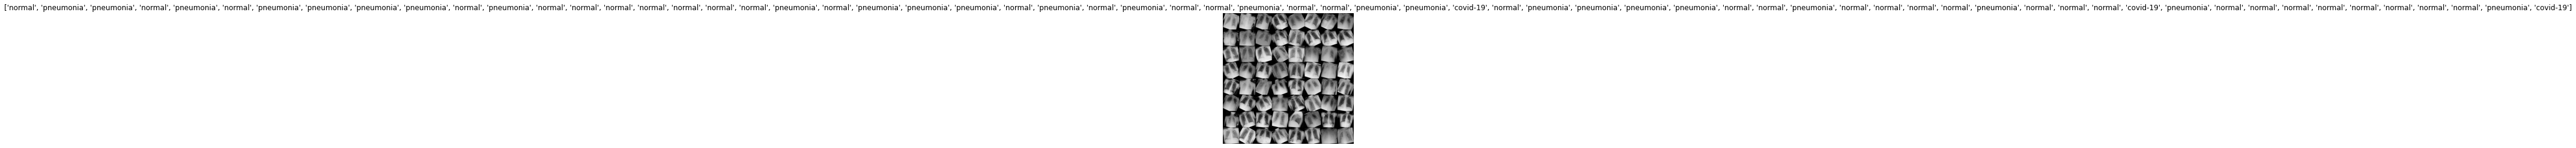

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, labels = next(iter(trainloader))

show_databatch(inputs, labels)

In [0]:
# def encoder(labels):
#   zTemp=torch.zeros(len(labels),3)  
#   for i in range(len(labels)):
#         if labels[i] == 0:
#             zTemp[i] = torch.tensor([1,1,0])
#         elif labels[i] == 2:
#             zTemp[i] = torch.tensor([0,1,0])
#         elif labels[i] == 1:
#             zTemp[i] = torch.tensor([0,0,1])
#   return zTemp

def encoder(a, num_classes):
  labels= torch.nn.functional.one_hot(a, num_classes)
  for i in range(labels[:,0].shape[0]):
    if(labels[:,0][i]==1):
      labels[:,2][i]=1
  return labels.float()

In [0]:
def get_model(name, pretrain):
    if name == 'vgg16':
        model = models.vgg16(pretrained=pretrain)

        num_features = model.classifier[6].in_features
        features = list(model.classifier.children())[:-1]
        for param in model.features.parameters():
            param.require_grad = True
          
        features.extend([nn.Linear(num_features, ((32*10)+100))])
        features.extend([nn.Linear(((32*10)+100), 3)])
        model.classifier = nn.Sequential(*features)

    elif name == 'resnet18':
        model = models.resnet18(pretrained=pretrain)
        
        for param in model.parameters():
          param.requires_grad = True
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(num_ftrs, ((32*10)+100)),
            nn.Linear(((32*10)+100), 3)
        )

    # get gpu
    if gpu: model = model.to('cuda')
    else: model = model.to('cpu')
    
    return model

In [9]:
# Check if gpu is available
gpu = cuda.is_available()
print('Gpu is available:',gpu)

Gpu is available: True


In [0]:
# # Get a batch of training data
# inputs, classes = next(iter(trainloader))
# show_databatch(inputs, classes)# Load the pretrained model from pytorch

vgg16 = get_model('vgg16', False)
# print(vgg16)
# print('Output Layer of resnet18 : ', vgg16.classifier[6].out_features) # 1000 

# # num_features = vgg16.classifier[6].in_features
# # features = list(vgg16.classifier.children())[:] 

# # vgg16.classifier[6].out_features = 1010

# features=([nn.Linear(25088,1010),nn.ReLU(inplace=True),nn.Linear(1010, 3)])




In [0]:
# vgg16.classifier = nn.Sequential(*features)
# print(vgg16)

In [12]:
# vgg16.classifier = nn.Sequential(*features)
print(vgg16)
Epochs = 10
criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.45)
# optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.45)
optimizer = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# def validLos(loader):
#    total=0.0
#    correct=0.0
#    running_loss=0.0   
#    losss=[]
#    pbar = tqdm(enumerate(loader))
#    for i, data in pbar:
#       # get the inputs
#       inputs, labels = data 

#       # labels= enc.transform(labels.numpy().reshape(-1,1)).toarray()
#       # labels = torch.from_numpy(labels)
#       hot_labels = encoder(labels,3)

#       inputs, hot_labels = inputs.to(device), hot_labels.to(device)

#       # forward + backward + optimize
#       outputs = vgg16(inputs)               #----> forward pass
#       labels=labels.unsqueeze(1)

#       loss = criterion(outputs, hot_labels)   #----> compute loss
#       losss.append(loss.item())
      
      
#       outputs=torch.sigmoid(outputs)
#       # print(outputs)

#       outputs[outputs < 0.4] = 0
#       outputs[outputs >= 0.4] = 1

#       total += hot_labels.size(0)
#       correct += (outputs == hot_labels).sum().item()
      

#       # _,pred=torch.max(outputs.data,dim=1)        
  
#           # print statistics
#       running_loss += loss.item()
#       pbar.set_description(
#           'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#               epoch, i * len(inputs), len(loader.dataset),
#               100. * i / len(loader),
#               loss.item()))         
      
#    accuracy=correct*100/total
#    return losss,len(data),accuracy/3

In [0]:
def focal_loss(targets,logits,eps,l):
  loss = torch.nn.functional.binary_cross_entropy_with_logits(logits, targets, reduction= 'none')# important to add reduction='none' to keep per-batch-item loss
  pyLoss = torch.exp(-loss)
  loss = (eps * (1-pyLoss)**l * loss).mean()
  return loss

In [15]:
from tqdm import tqdm
device = torch.device("cuda")

train_labels = list()
train_preds = list()
val_labels = list()
val_preds = list()

vgg16.to(device)
vgg16.train()

stats = []
print('Training Started.......')
    
for epoch in range(Epochs):  # loop over the dataset multiple times
  vgg16.train()
  acc=[]
  temp=[]
  running_loss = 0.0
  l=0
  lebelsTemp=[]


  train_loss = 0.0
  train_acc = 0.0
  valid_loss = 0.0
  valid_acc = 0.0
  pbar = tqdm(enumerate(trainloader))
  for i, data in pbar:
      inputs, labels = data
      labels = encoder(labels, 3)
      inputs, labels = inputs.to(device), labels.to(device)
      
      optimizer.zero_grad()

      outputs = vgg16(inputs)               
      loss = criterion(outputs, labels)   
      # loss = focal_loss(labels, outputs, 0.25, 2)
      # loss = criterion(outputs,labels)
      loss.backward()                    
      optimizer.step()    
      
      # print statistics
      train_loss += loss.item() * inputs.size(0)

      # Calculate train accuracy
      pred = torch.sigmoid(outputs)
      pred[pred <= 0.5] = 0
      pred[pred > 0.5] = 1
      # _, pred = torch.max(outputs, dim=1)
      correct_tensor = pred.eq(labels.data.view_as(pred))
      accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
      train_acc += accuracy.item() * inputs.size(0)

      if epoch == Epochs -1:
        train_labels.extend(labels.cpu().tolist())
        train_preds.extend(pred.cpu().tolist())

  train_loss = train_loss / len(trainloader.dataset)
  train_acc = train_acc / len(trainloader.dataset)

    # We don't need to save grads because no backprop is required for validation set
  with torch.no_grad():
      vgg16.eval()
      # Validation dataset pass
      for i, data in enumerate(validloader):
          # get the inputs
          inputs, labels = data
          inputs, labels = data
          labels = encoder(labels, 3)
          inputs, labels = inputs.to(device), labels.to(device)
          # print(labels[:5])
          # break

          # Validation loss
          outputs = vgg16(inputs) 
          loss = criterion(outputs, labels)
          # loss = focal_loss(labels, outputs, 0.25, 2)
          valid_loss += loss.item() * inputs.size(0)
          
          
          # Calculate validation accuracy
          pred = torch.sigmoid(outputs)
          pred[pred <= 0.5] = 0
          pred[pred > 0.5] = 1
          # _, pred = torch.max(outputs, dim=1)
          correct_tensor = pred.eq(labels.data.view_as(pred))
          accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
          valid_acc += accuracy.item() * inputs.size(0)

          if epoch == Epochs-1:
            val_labels.extend(labels.cpu().tolist())
            val_preds.extend(pred.cpu().tolist())

      valid_loss = valid_loss / len(validloader.dataset)
      valid_acc = valid_acc / len(validloader.dataset)

      vgg16.optimizer = optimizer
      stats.append([train_loss, valid_loss, train_acc, valid_acc])
  print('Epoch',epoch+1,':',f' Training Loss: {train_loss:.4f},',f'Training Accuracy: {100 * train_acc:.3f}%', f' Validation Loss: {valid_loss:.4f},',f'Validation Accuracy: {100 * valid_acc:.3f}%')
  stat = pd.DataFrame(stats, columns=['train_loss', 'valid_loss', 'train_acc','valid_acc'])
  torch.save(vgg16, '/content/models/VGG_BCE.pth')

print('Finished Training')

Training Started.......


97it [02:44,  1.70s/it]


Epoch 1 :  Training Loss: 0.5098, Training Accuracy: 73.059%  Validation Loss: 0.4971, Validation Accuracy: 74.310%


97it [02:45,  1.71s/it]


Epoch 2 :  Training Loss: 0.4114, Training Accuracy: 80.715%  Validation Loss: 0.3794, Validation Accuracy: 84.979%


97it [02:45,  1.70s/it]


Epoch 3 :  Training Loss: 0.3531, Training Accuracy: 86.473%  Validation Loss: 0.4035, Validation Accuracy: 85.032%


97it [02:45,  1.71s/it]


Epoch 4 :  Training Loss: 0.3215, Training Accuracy: 87.984%  Validation Loss: 0.3289, Validation Accuracy: 87.951%


97it [02:46,  1.71s/it]


Epoch 5 :  Training Loss: 0.3125, Training Accuracy: 88.043%  Validation Loss: 0.3173, Validation Accuracy: 88.641%


97it [02:46,  1.71s/it]


Epoch 6 :  Training Loss: 0.2982, Training Accuracy: 88.731%  Validation Loss: 0.3133, Validation Accuracy: 88.694%


97it [02:46,  1.72s/it]


Epoch 7 :  Training Loss: 0.2902, Training Accuracy: 88.753%  Validation Loss: 0.3160, Validation Accuracy: 87.951%


97it [02:46,  1.72s/it]


Epoch 8 :  Training Loss: 0.2854, Training Accuracy: 89.290%  Validation Loss: 0.3184, Validation Accuracy: 87.420%


97it [02:46,  1.72s/it]


Epoch 9 :  Training Loss: 0.2833, Training Accuracy: 89.188%  Validation Loss: 0.2966, Validation Accuracy: 89.066%


97it [02:46,  1.72s/it]


Epoch 10 :  Training Loss: 0.2774, Training Accuracy: 89.532%  Validation Loss: 0.2847, Validation Accuracy: 88.960%
Finished Training


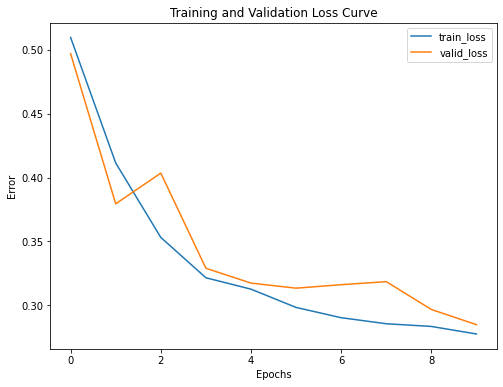

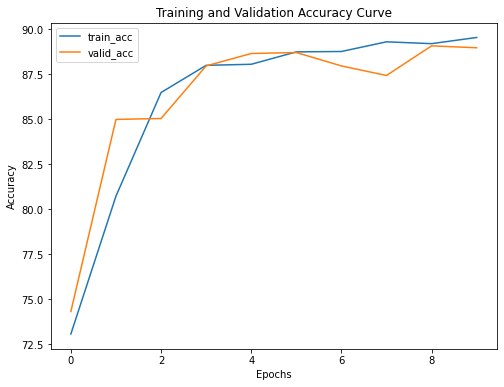

In [16]:
def plotCurves(stats):
    plt.figure(figsize=(8, 6))
    for c in ['train_loss', 'valid_loss']:
        plt.plot(stats[c], label=c)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Training and Validation Loss Curve')

    plt.figure(figsize=(8, 6))
    for c in ['train_acc', 'valid_acc']:
        plt.plot(100 * stats[c], label=c)
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curve')
    plt.show()
plotCurves(stat)

Text(0.5, 1.05, 'VGG-16 Training CF with BCE (Matrix 2)')

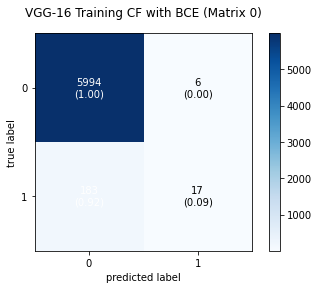

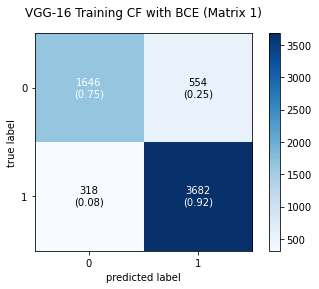

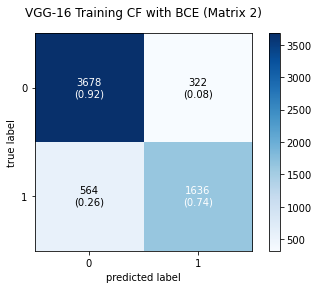

In [17]:
from sklearn.metrics import multilabel_confusion_matrix, f1_score
from mlxtend.plotting import plot_confusion_matrix

cm = multilabel_confusion_matrix(np.array(train_labels), np.array(train_preds))#, labels=['Covid-19', 'Normal', 'Pneumonia'])
fig, ax = plot_confusion_matrix(conf_mat=cm[0], show_absolute=True, show_normed=True, colorbar=True)
plt.title('VGG-16 Training CF with BCE (Matrix 0)')

fig, ax = plot_confusion_matrix(conf_mat=cm[1], show_absolute=True, show_normed=True, colorbar=True)
plt.title('VGG-16 Training CF with BCE (Matrix 1)')

fig, ax = plot_confusion_matrix(conf_mat=cm[2], show_absolute=True, show_normed=True, colorbar=True)
plt.title('VGG-16 Training CF with BCE (Matrix 2)')

Text(0.5, 1.05, 'VGG-16 Validation CF with BCE (Matrix 2)')

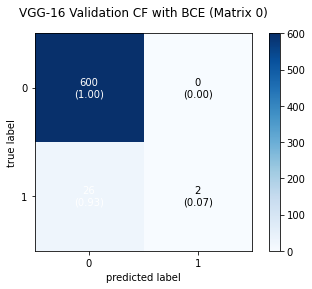

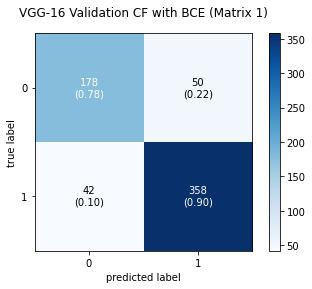

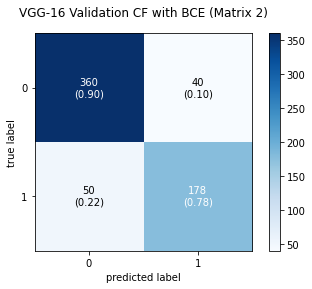

In [18]:
cm = multilabel_confusion_matrix(np.array(val_labels), np.array(val_preds))#, labels=['Covid-19', 'Normal', 'Pneumonia'])
fig, ax = plot_confusion_matrix(conf_mat=cm[0], show_absolute=True, show_normed=True, colorbar=True)
plt.title('VGG-16 Validation CF with BCE (Matrix 0)')

fig, ax = plot_confusion_matrix(conf_mat=cm[1], show_absolute=True, show_normed=True, colorbar=True)
plt.title('VGG-16 Validation CF with BCE (Matrix 1)')

fig, ax = plot_confusion_matrix(conf_mat=cm[2], show_absolute=True, show_normed=True, colorbar=True)
plt.title('VGG-16 Validation CF with BCE (Matrix 2)')

In [19]:
print('Mode; Focal Train F1 Score: %f ' %(f1_score(train_labels, train_preds,average='samples')))
print('Model Focal Validation F1 Score: %f ' %(f1_score(val_labels, val_preds,average='samples')))

Mode; Focal Train F1 Score: 0.851532 
Model Focal Validation F1 Score: 0.849257 


#Test Loader

In [0]:
# model_save_name = 'classifier.pt'
# path = F"/content/gdrive/My Drive/{model_save_name}" 
# torch.save(model.state_dict(), path)

# # Load the trained model
# model_save_name = 'classifier.pt'
# path = F"/content/gdrive/My Drive/{model_save_name}"
# # model2=model.load_state_dict(torch.load(path))
model2=torch.load('/content/models/RESNET_focal_loss.pth')


In [0]:
testPath='/content/A_05_Part_02_Dataset/newTest'
test_data = datasets.ImageFolder(testPath, transform=test_transforms)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True,num_workers=4)


In [0]:
model2=model2.to('cuda')
pred=[]
with torch.no_grad():
  model2.eval()
  for data in testloader:
    images,labels=data
    images, labels = images.to(device), labels.to(device)
    outputs=model2(images)
    prediction=torch.sigmoid(outputs)
    prediction[prediction < 0.5] = 0
    prediction[prediction >= 0.5] = 1
    pred.extend(prediction.cpu().tolist())

In [0]:
files = test_data.imgs
file_names = []
for each in files:
  file_names.append(each[0].split('/')[-1])
file_names[:2]


In [0]:
import pandas as pd

df = pd.DataFrame({'Files': file_names, 'Predictions': pred})
df.to_csv('MSDS19091_results.csv',index=False)